# WSPRd Grape Doppler Spectrogram
Nathaniel Frissell W2NAF - 28 Dec 2023

This Jupyter notebook will take a WAV file of HF Doppler observations created by WSPRd and generate a time domain time series and a frequency domain spectrogram.

`grape.wav` was provided by Rob Robinett AI6VN on 26 December 2023. The signal processing chain for this file is: RX888 == 64.8 Msps => KA9Q-radio -> continuous series of one minute long 16,000 sps  IQ wsv files => 240 of those wv files processed by sox into one 240 minute 10 sps IQ wav file.

Modified by Michael Hauan AC0G - 01 Mar 2024
Assumes a standard wsprdaemon setup and directory structure.
Prompts for a date and a channel.
Displays the spectrogram of the same 24-hour wav file converted to digital_rf and uploaded to PSWS server.

## Load Libraries and Set Plotting Defaults

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import os

from scipy import signal
from scipy.io import wavfile

%matplotlib inline

In [66]:
# Matplotlib settings to make the plots look a little nicer.

plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (10,6)

## Define Custom Functions

In [67]:
def plot_cxSig(t,xx,xlim=None,ylim=None,flim=None,title=None,xunit='s'):
    """
    Plot the time domain and spectrogram of a signal.
    t:  Time Vector in seconds.
    xx: time-domain signal
    
    xlim: (x0, x1) Limits of x-axis (in seconds) for both time series and spectrograms.
    ylim: (y0, y1) Limits of time series plot y-axis.
    flim: (f0, f1) Limits of spectrogram plot y-axis.
    
    title: Title for entire plot.
    
    xunit: Time unit for plotting x-axis. The input time vector (in seconds) will be converted to the new unit.
        's': Seconds
        'min': minutes
        'hr': hours
    """
    
    # Compute the Sample Rate
    fs = 1/(t[1]-t[0])

    f, t_spec, Sxx = signal.spectrogram(xx,fs=fs,window='hann',return_onesided=False)
    f    = np.fft.fftshift(f)
    Sxx  = np.fft.fftshift(Sxx,axes=0)
    Sxx_db = 10*np.log10(Sxx)

    if xunit == 's':
        tt      = t
        tt_spec = t_spec
        xlabel  = 't [s]'
    elif xunit == 'min':
        tt      = t/60.
        tt_spec = t_spec/60.
        xlabel  = 't [min]'
    elif xunit == 'hr':
        tt      = t/3600.
        tt_spec = t_spec/3600.
        xlabel  = 't [hr]'
    
    fig = plt.figure(figsize=(15,7))

    ax0  = fig.add_subplot(2,1,1)
    ax0.plot(tt,np.real(xx),label='Real')
    ax0.plot(tt,np.imag(xx),label='Imag')
    ax0.set_xlabel(xlabel)
    ax0.set_ylabel('Amplitude')
    ax0.set_xlim(xlim)
    ax0.set_ylim(ylim)
    ax0.legend(loc='upper right',fontsize='small')

    ax1  = fig.add_subplot(2,1,2)
    mpbl = ax1.pcolormesh(tt_spec,f,Sxx_db)
    cbar = fig.colorbar(mpbl,label='PSD [dB]')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('f [Hz]')
    ax1.set_xlim(xlim)
    ax1.set_ylim(flim)
    
    if title is not None:
        ax0.set_title(title)

    fig.tight_layout()

    # The next three lines make sure the time-domain plot lines up properly with the spectrogram.
    ax0p = ax0.get_position().bounds
    ax1p = ax1.get_position().bounds
    ax0.set_position((ax0p[0],ax0p[1],ax1p[2],ax0p[3]))

    #plt.show()
    #plt.savefig("WWV_10.png")


In [68]:
def find_subdirectory(path):
    """Automatically find and return the path to the single subdirectory under the given path."""
    subdirectories = [os.path.join(path, d) for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    if len(subdirectories) == 1:
        return subdirectories[0]  # Return the only subdirectory path
    else:
        raise ValueError(f"Expected exactly one subdirectory under {path}, but found {len(subdirectories)}.")


In [69]:
def list_dates(base_path):
    """List available dates in the base directory, sorted in ascending order."""
    try:
        dates = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
        dates.sort()  # Sort the dates in ascending order
        return dates
    except FileNotFoundError:
        print("Base directory not found.")
        return []

In [70]:
def list_channels(date_path):
    """List available channels for the selected date, including those starting with 'WWV' or 'CHU'."""
    channels = []
    for root, dirs, files in os.walk(date_path):
        for dir in dirs:
            if dir.startswith("WWV_") or dir.startswith("CHU_"):  # Check for both 'WWV' and 'CHU'
                channels.append(dir)
        break  # Only need the first level under the selected date
    return channels

In [71]:
def get_user_selection(options, prompt):
    """Prompt user to select an option from a list."""
    if not options:
        print("No options available.")
        return None
    for i, option in enumerate(options, start=1):
        print(f"{i}. {option}")
    while True:
        try:
            choice = int(input(prompt))
            if 1 <= choice <= len(options):
                return options[choice-1]
            else:
                print("Invalid selection. Please try again.")
        except ValueError:
            print("Please enter a number.")


In [72]:
base_path = "/home/wsprdaemon/wsprdaemon/wav-archive.d"
dates = list_dates(base_path)
date = get_user_selection(dates, "Select a date by entering the number: ")
if date is None:
    raise ValueError("Invalid date selection. Please restart and select a valid date.")

date_path = os.path.join(base_path, date)

# Automatically navigate through the next two levels, assuming each has only one subdirectory
first_level_path = find_subdirectory(date_path)
second_level_path = find_subdirectory(first_level_path)

channels = list_channels(second_level_path)
channel = get_user_selection(channels, "Select a channel by entering the number: ")
if channel is None:
    raise ValueError("Invalid channel selection. Please restart and select a valid channel.")

# Assuming the file structure is consistent and only one .wav file is needed
wav_file_path = os.path.join(second_level_path, channel, "24_hour_10sps_iq.wav")
print(f"The directory path to the .wav file is: {wav_file_path}")

# Check if the file exists before attempting to load it
if not os.path.isfile(wav_file_path):
    raise FileNotFoundError(f"The WAV file does not exist at the specified path: {wav_file_path}")

# Load in the file and detect the sampling frequency
fname1 = wav_file_path
fs_wav1, wav1 = wavfile.read(fname1)


1. 20240109
2. 20240110
3. 20240111
4. 20240112
5. 20240113
6. 20240114
7. 20240115
8. 20240116
9. 20240117
10. 20240118
11. 20240119
12. 20240120
13. 20240121
14. 20240122
15. 20240123
16. 20240124
17. 20240125
18. 20240126
19. 20240127
20. 20240128
21. 20240129
22. 20240130
23. 20240131
24. 20240201
25. 20240202
26. 20240203
27. 20240204
28. 20240205
29. 20240206
30. 20240207
31. 20240208
32. 20240209
33. 20240210
34. 20240211
35. 20240212
36. 20240213
37. 20240214
38. 20240215
39. 20240216
40. 20240217
41. 20240218
42. 20240219
43. 20240220
44. 20240221
45. 20240222
46. 20240223
47. 20240224
48. 20240225
49. 20240226
50. 20240227
51. 20240228
52. 20240229
53. 20240301


Select a date by entering the number:  52


1. WWV_25
2. CHU_14
3. WWV_5
4. CHU_3
5. CHU_7
6. WWV_10
7. WWV_20
8. WWV_15
9. WWV_2_5


Select a channel by entering the number:  3


The directory path to the .wav file is: /home/wsprdaemon/wsprdaemon/wav-archive.d/20240229/AC0G_EM38ww/KA9Q_0_WWV_IQ@S000123_131/WWV_5/24_hour_10sps_iq.wav


In [73]:
# Print unmodified data
# wav1, fs_wav1

In [74]:
# Convert data from 2 columns to a single vector of complex data
wav1 = wav1[:,0] + 1j*wav1[:,1]

# Calculate a time vector in seconds
duration      = len(wav1) * 1/fs_wav1
t_wav1        = np.arange(len(wav1))*(1/fs_wav1) 

In [75]:
# Print out the wav1 vector
wav1

array([ -74. +64.j, -121.+158.j,  -73.+165.j, ...,   33. -53.j,
         33. -48.j,   56. -29.j])

In [76]:
# Print out the samplerate
fs_wav1

10

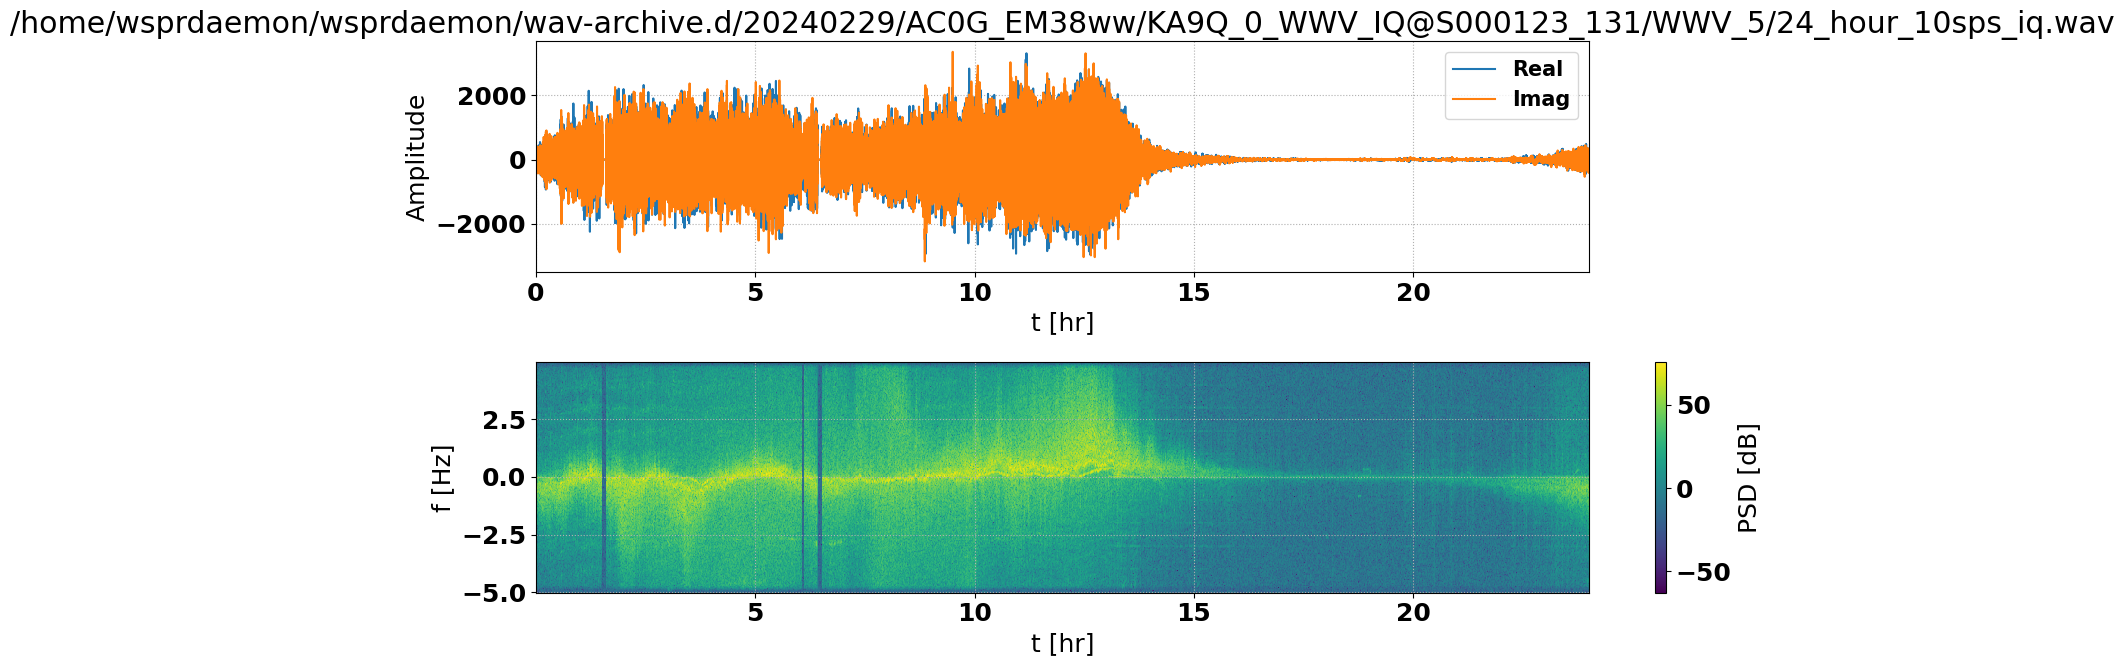

In [77]:
# Plot the signal and spectrogram.
plot_cxSig(t_wav1,wav1,title=fname1,xunit='hr')